# Data preprocessing

## emotion label + path to file

# Plots

## class distribution

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
def class_imbalance_plot():
    print(df['emotion'].unique())
    plt.figure(figsize = (12,6))
    sns.set_theme(style='darkgrid')
    sns.countplot(x = 'emotion', data = df)
    plt.title('Class distribution')
    plt.savefig(imgs_path + 'class_distribution.png')
    plt.show()
    return

class_imbalance_plot()

anger        2167
neutral      1860
sadness      1493
happiness    1251
anxiety      1087
surprise      901
disgust       844
calm          376
Name: emotion, dtype: int64

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [46]:
# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(path_to_file, _sr, _duration):
    # load file
    wavf, sample_rate = librosa.load(path_to_file, res_type="kaiser_fast", duration=_duration, sr=_sr)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 44100, 9)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,database,emotion,0,1,2,3,4,5,6,7,...,766,767,768,769,770,771,772,773,774,775
0,emodb,anger,-36.090981,-32.796627,-31.116634,-29.469265,-29.919529,-33.353619,-34.865524,-19.824419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,emodb,sadness,-26.864872,-24.903822,-24.706491,-25.334080,-26.270023,-25.506786,-24.641876,-24.913900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,emodb,anxiety,-26.956562,-27.515024,-26.380819,-25.832865,-27.194027,-26.763607,-28.808035,-27.407793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,emodb,sadness,-24.535583,-23.440098,-20.839142,-20.759388,-21.358418,-21.638031,-23.573610,-22.106657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,emodb,disgust,-34.375870,-29.413809,-28.761814,-29.789680,-28.418623,-29.296476,-30.873238,-28.353069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data split

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # stratified train, test split
    train, test = train_test_split(df, test_size=0.2,random_state=0, stratify=df[['emotion', 'database']])
    
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    X_train = train.iloc[:, :].drop(columns=['emotion', 'database'])
    y_train = train['emotion']
    
    X_test = test.iloc[:, :].drop(columns=['emotion', 'database'])
    y_test = test['emotion']
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

            0          1          2          3          4          5    \
3011 -51.914497 -55.741245 -63.201897 -62.930744 -63.228577 -63.663383   
8688 -21.407433 -18.251057 -15.450384 -15.813558 -19.583677 -19.756838   
3701 -43.793922 -42.403622 -42.918903 -41.546028 -40.341286 -41.125095   
596  -44.178215 -41.919498 -41.906723 -42.786770 -42.484978 -42.649368   
2411 -64.685684 -64.685684 -64.685684 -64.685684 -64.685684 -64.685684   

            6          7          8          9    ...  766  767  768  769  \
3011 -64.344002 -63.579494 -64.460480 -65.620560  ...  0.0  0.0  0.0  0.0   
8688 -14.000358 -11.121046  -9.865792 -12.560953  ...  0.0  0.0  0.0  0.0   
3701 -39.823349 -37.169167 -36.150612 -37.927967  ...  0.0  0.0  0.0  0.0   
596  -43.076218 -42.876701 -42.619450 -41.014408  ...  0.0  0.0  0.0  0.0   
2411 -64.685684 -64.685684 -64.685684 -64.685684  ...  0.0  0.0  0.0  0.0   

      770  771  772  773  774  775  
3011  0.0  0.0  0.0  0.0  0.0  0.0  
8688  0.0  0.0  0.

# Data preprocessing

In [48]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

2022-04-09 19:23:17.158168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(7983,)
(1996,)
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
['anger' 'anxiety' 'calm' 'disgust' 'happiness' 'neutral' 'sadness'
 'surprise']
(7983, 776, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2

def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model

'''
# this simple model gives around 30% accuracy
def get_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model
'''


'''
# this model gives around 35% accuracy
def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(96, kernel_size=15, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.MaxPooling1D(pool_size=3, strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(256, kernel_size=5, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=3, strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model
'''

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 767, 64)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 758, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 94, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 94, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 85, 128)           163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

2022-04-09 19:23:47.436283: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-09 19:23:47.447334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-09 19:23:47.536503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 19:23:47.537022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-04-09 19:23:47.537130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-09 19:23:47.584234: I tensorflow/stream_executor/platfor

# Model training and export

2022-04-09 19:23:55.883320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-09 19:23:55.906402: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz
2022-04-09 19:23:56.372832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-09 19:23:56.766926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-09 19:23:58.082325: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-09 19:23:58.103646: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to alloc


Epoch 00001: val_accuracy improved from -inf to 0.32916, saving model to ../models/cross_corpus/model_1_CNN


2022-04-09 19:24:01.655970: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00002: val_accuracy improved from 0.32916 to 0.39228, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00003: val_accuracy improved from 0.39228 to 0.40381, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00004: val_accuracy improved from 0.40381 to 0.45441, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00005: val_accuracy improved from 0.45441 to 0.45792, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00006: val_accuracy improved from 0.45792 to 0.50000, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corp

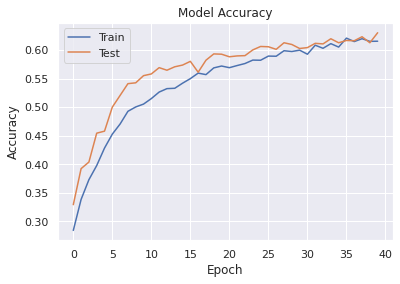

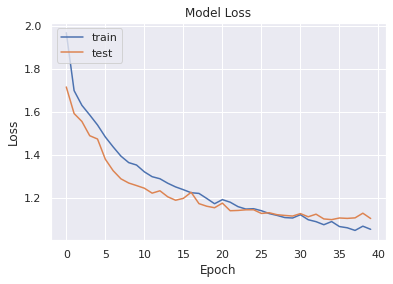

In [50]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint = ModelCheckpoint(models_path + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgs_path + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgs_path + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [51]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

63/63 [==============================] - 0s 6ms/step - loss: 1.1040 - accuracy: 0.6303
Loss of the model is -  1.1040164232254028
63/63 [==============================] - 0s 6ms/step - loss: 1.1040 - accuracy: 0.6303
Accuracy of the model is -  63.026052713394165 %


In [52]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,sadness,sadness
2,anger,disgust
3,sadness,sadness
4,anger,anger
5,anger,anger
6,anxiety,anxiety
7,calm,calm
8,calm,calm
9,happiness,happiness


## confusion matrix

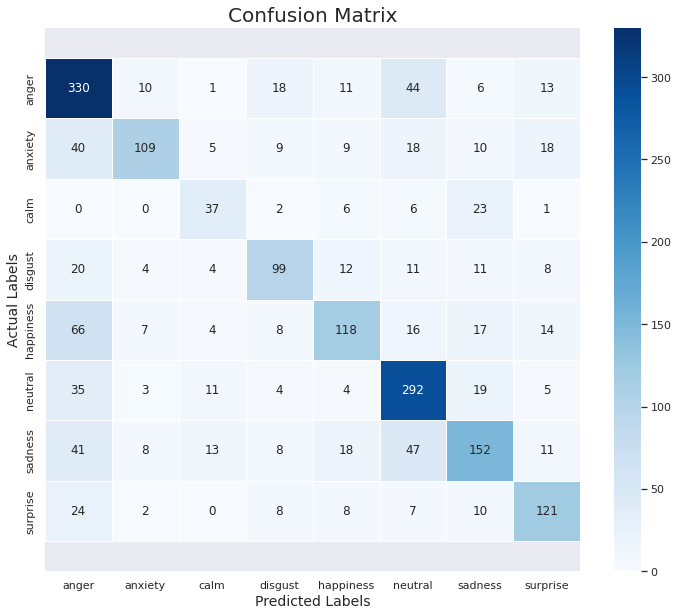

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgs_path + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [54]:
print(classification_report(actual, predictions, target_names = ['anger', 'anxiety', 'calm', 'disgust', 'happiness',
                                                                 'neutral', 'sadness', 'surprise']))

              precision    recall  f1-score   support

       anger       0.59      0.76      0.67       433
     anxiety       0.76      0.50      0.60       218
        calm       0.49      0.49      0.49        75
     disgust       0.63      0.59      0.61       169
   happiness       0.63      0.47      0.54       250
     neutral       0.66      0.78      0.72       373
     sadness       0.61      0.51      0.56       298
    surprise       0.63      0.67      0.65       180

    accuracy                           0.63      1996
   macro avg       0.63      0.60      0.61      1996
weighted avg       0.64      0.63      0.62      1996

